# Networks of Awards





In [32]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [33]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [34]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [35]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\UniNe\\Master année 1\\semestre 2\\Les-as-de-la-Grande-Guerre-\\notebooks jupyter\\network_analysis_functions.py'>


## Get the data from the triplestore

Ce carnet s’appuie sur les mêmes relations (et donc les mêmes données) que celles utilisées dans l’analyse bivariée des décorations et des alliances. Il s’agit plus précisément des liens entre les pilotes et les distinctions militaires qu’ils ont reçues, ainsi que leur appartenance nationale (ou bloc d’alliance).

Dans ce carnet, nous proposons une lecture en termes de réseau de ces relations, en construisant une structure de graphe basée sur les décorations attribuées.

L’objectif est de mettre en évidence les structures sous-jacentes dans le système de récompenses militaires pendant la Première Guerre mondiale, d’identifier les pays ou alliances les plus centraux dans ce réseau, et de déceler d’éventuels regroupements (clusters) de pays en fonction de leur profil de distinctions.


In [36]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [37]:
query = """
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT
  ?ace ?aceLabel
  ?allegiance ?allegLabel
  ?award ?awardLabel
  ?birthYear
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {

    ?ace rdfs:label ?aceLabel .
    ?ace wdt:P945 ?allegiance .
    ?allegiance rdfs:label ?allegLabel .

    OPTIONAL {
      ?ace wdt:P166 ?award .
      ?award rdfs:label ?awardLabel .
    }
    OPTIONAL {
      ?ace wdt:P569 ?birthDate .
      BIND(xsd:integer(SUBSTR(STR(?birthDate), 1, 4)) AS ?birthYear)
    }
  }
}
ORDER BY ?birthYear


"""

In [38]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


2383
[['http://www.wikidata.org/entity/Q4757076',
  'Andrew George Board',
  'http://www.wikidata.org/entity/Q174193',
  'United Kingdom of Great Britain and Ireland',
  'http://www.wikidata.org/entity/Q12177413',
  'Companion of the Order of St Michael and St George',
  '1878'],
 ['http://www.wikidata.org/entity/Q7087865',
  'Oliver Swann',
  'http://www.wikidata.org/entity/Q174193',
  'United Kingdom of Great Britain and Ireland',
  'http://www.wikidata.org/entity/Q12177470',
  'Knight Commander of the Order of the Bath',
  '1878'],
 ['http://www.wikidata.org/entity/Q4757076',
  'Andrew George Board',
  'http://www.wikidata.org/entity/Q174193',
  'United Kingdom of Great Britain and Ireland',
  'http://www.wikidata.org/entity/Q615838',
  'Distinguished Service Order',
  '1878']]


## Inspect the data


In [39]:
df_awards = pd.DataFrame(out)
df_awards.columns = [
    'aceUri',
    'aceLabel',
    'allegianceUri',
    'allegianceLabel',
    'awardUri',
    'awardLabel',
    'birthYear'
]
print('Nombre de lignes :', len(df_awards))
df_awards.iloc[100:103, :]


Nombre de lignes : 2383


,aceUri,aceLabel,allegianceUri,allegianceLabel,awardUri,awardLabel,birthYear
100,http://www.wikidata.org/entity/Q4757076,Andrew George Board,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q12177413,Companion of the Order of St Michael and St Ge...,1878
101,http://www.wikidata.org/entity/Q7087865,Oliver Swann,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q12177470,Knight Commander of the Order of the Bath,1878
102,http://www.wikidata.org/entity/Q4757076,Andrew George Board,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q615838,Distinguished Service Order,1878


### Distribution of relationships in relation to birthYears of organisations members

In [40]:
l_5 = list(range(1850, 1905, 5))
print(l_5)

[1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900]


In [41]:
### We adapt the periods manually,
# we would like to have eleven periods
# making sense from an historical point of view 
lc = [1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905]

In [42]:
### convert birthYear to integer
df_awards.birthYear = df_awards.birthYear.apply(lambda x : int(x))

In [43]:
### En premier lieu, on nettoit les données de bases pour éviter les doublons (tels que "Kingdom of Italy" et "Italy")

df_awards["allegianceLabel"] = df_awards["allegianceLabel"].str.strip()

allegiance_clean_map = {
    # Italy
    "Kingdom of Italy": "Italy",
    "Italy": "Italy",

    # UK and dominions
    "United Kingdom of Great Britain and Ireland": "United Kingdom",
    "United Kingdom": "United Kingdom",
    "British Empire": "United Kingdom",

    # Germany
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",
    "Kingdom of Saxony": "Germany",
    "Kingdom of Prussia": "Germany",
    "Kingdom of Bavaria": "Germany",

    # Austria-Hungary
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",  # en-dash version
    "Austria": "Austria-Hungary",
    "Hungary": "Austria-Hungary",
    "Kingdom of Hungary": "Austria-Hungary",

    # Poland
    "Second Polish Republic": "Poland",

    # Romania
    "Kingdom of Romania": "Romania",

    # Hungary
    "Kingdom of Hungary": "Hungary",
    "Hungary": "Hungary",

    # Russia
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
}

# Apply mapping
df_awards["allegiance_clean"] = df_awards["allegianceLabel"].replace(allegiance_clean_map)



In [44]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_awards['periods'] = pd.cut(df_awards['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_awards['periods'] = df_awards['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_awards.iloc[[1,5,10]]

,aceUri,aceLabel,allegianceUri,allegianceLabel,awardUri,awardLabel,birthYear,allegiance_clean,periods
1,http://www.wikidata.org/entity/Q6225085,John Capper,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q12177470,Knight Commander of the Order of the Bath,1861,United Kingdom,1860-1864
5,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q15117228,Knight of the Order of the Golden Fleece,1862,Germany,1860-1864
10,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q1126563,Order of St. Andrew,1862,Germany,1860-1864


In [45]:
### Group by periods
df_period = df_awards.groupby(by='periods', observed=True).size()
print(df_period)

periods
1860-1864     21
1865-1869     18
1870-1874     26
1875-1879     77
1880-1884    187
1885-1889    376
1890-1894    825
1895-1899    813
1900-1904     40
dtype: int64


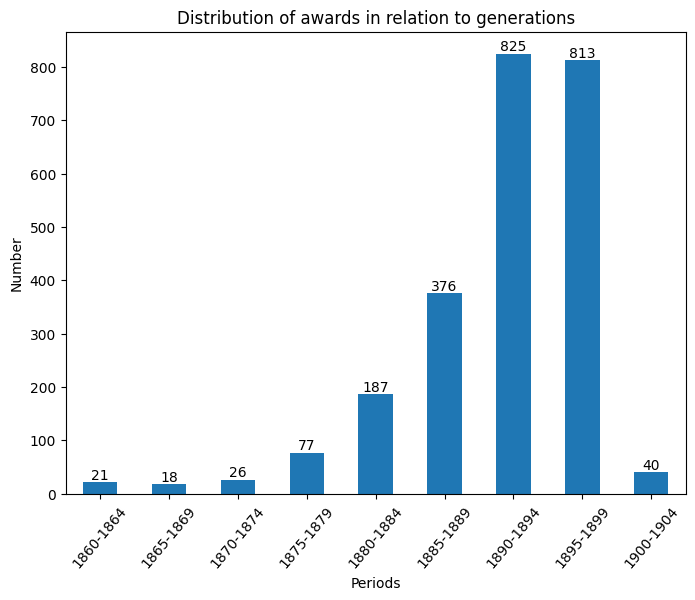

In [46]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of awards in relation to generations')
plt.show()

### Inspect available relationships

In [47]:
### On compte les awards les plus communs
print(df_awards.groupby('awardLabel').size().sort_values(ascending=False).head(10))


awardLabel
                                        218
Croix de guerre 1914–1918               129
Knight of the Legion of Honour          101
Distinguished Flying Cross               75
Medal of Military Valour                 74
Silver Cross of the Virtuti Militari     54
Military Cross                           53
Médaille militaire                       48
Distinguished Service Order              46
Officer of the Legion of Honour          46
dtype: int64


In [48]:
dfg_pr = df_awards.groupby(by=['periods', 'allegiance_clean'], observed=True, as_index=False).size()
print(dfg_pr.head(10))



     periods allegiance_clean  size
0  1860-1864          Germany    11
1  1860-1864            Italy     8
2  1860-1864   United Kingdom     2
3  1865-1869           France    10
4  1865-1869          Germany     1
5  1865-1869          Hungary     1
6  1865-1869            Italy     1
7  1865-1869   United Kingdom     4
8  1865-1869    United States     1
9  1870-1874           France     8


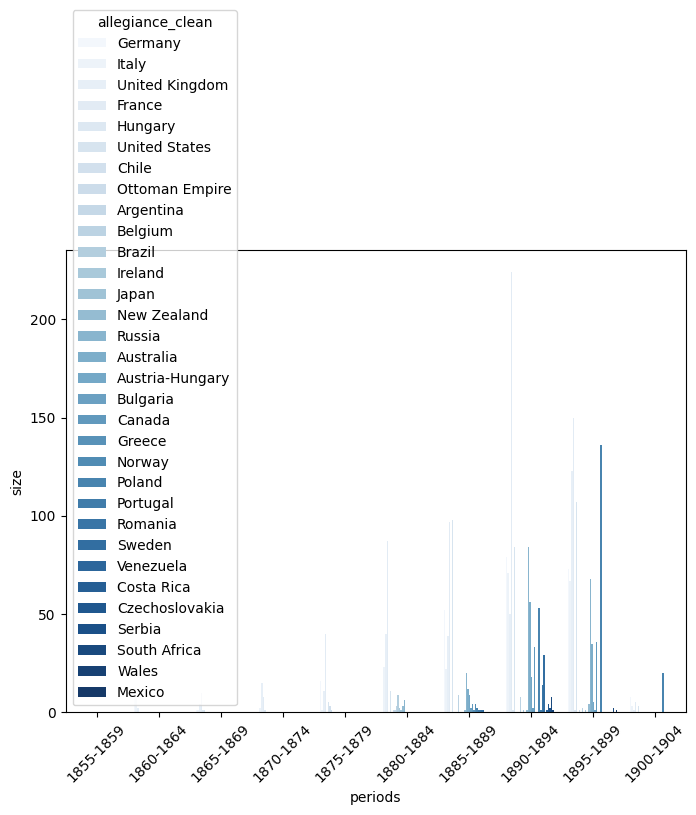

In [49]:
## le graphique suivant montre que nous avons trop d'allégeances pour des analyses claires. Il faut procéder à une sélection.
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='allegiance_clean', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up: choice of allegiances

In [50]:
# Nettoyage + regroupement des allégeances dans des blocs cohérents
allegiance_clean_map = {
    # British Empire
    "United Kingdom of Great Britain and Ireland": "British Empire",
    "United Kingdom": "British Empire",
    "British Empire": "British Empire",
    "Canada": "British Empire",
    "Australia": "British Empire",
    "New Zealand": "British Empire",
    "Ireland": "British Empire",

    # France
    "France": "France",

    # Germany
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",

    # Austria-Hungary
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",  # en-dash
    "Austria": "Austria-Hungary",

    # Italy
    "Italy": "Italy",
    "Kingdom of Italy": "Italy",

    # USA
    "United States": "United States",

    # Russia
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
    "Russia": "Russia",
}



In [51]:
df_awards["allegiance_clean"] = df_awards["allegianceLabel"].replace(allegiance_clean_map)


main_alliances = [
    "France", "British Empire", "Germany", 
    "Austria-Hungary", "Italy", "United States", "Russia"
]

# On regroupe le rest dans other
df_awards["allegiance_clean"] = df_awards["allegiance_clean"].apply(
    lambda x: x if x in main_alliances else "Other"
)

df_awards.iloc[[1,20,80]]

,aceUri,aceLabel,allegianceUri,allegianceLabel,awardUri,awardLabel,birthYear,allegiance_clean,periods
1,http://www.wikidata.org/entity/Q6225085,John Capper,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q12177470,Knight Commander of the Order of the Bath,1861,British Empire,1860-1864
20,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,http://www.wikidata.org/entity/Q172579,Kingdom of Italy,http://www.wikidata.org/entity/Q163700,Legion of Honour,1863,Italy,1860-1864
80,http://www.wikidata.org/entity/Q5481885,Francis McClean,http://www.wikidata.org/entity/Q174193,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q833163,Knight Bachelor,1876,British Empire,1875-1879


In [52]:
## On vérifie que le regroupement a bien eu lieu
print(df_awards["allegiance_clean"].value_counts())



allegiance_clean
France             621
British Empire     474
Other              338
United States      309
Germany            233
Italy              198
Russia             178
Austria-Hungary     32
Name: count, dtype: int64


#### Save dataframe to CSV

In [53]:
###file_add = 'C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\data\main_awards_allegiance.csv'
## df_awards.to_csv(file_add, index=False, sep=',', quotechar='"')

# Create graphs

In [54]:
### Available relationships
print(df_awards.columns)


Index(['aceUri', 'aceLabel', 'allegianceUri', 'allegianceLabel', 'awardUri',
       'awardLabel', 'birthYear', 'allegiance_clean', 'periods'],
      dtype='object')


### Prepare the dataframe

In [55]:
# Prepare dataframe for network analysis: pilots ↔ awards
df_prep = df_awards[['aceUri', 'aceLabel', 'awardLabel', 'allegiance_clean', 'periods']].copy(deep=True)

print(len(df_prep))


2383


### Features of award

#### General grouping


We first group by awards. 

In [56]:
# Group awards and count number of pilots who received them
df_award_stats = (
    df_prep
    .groupby(['awardLabel'], as_index=False)
    .size()
    .rename(columns={'size': 'nb_pilots'})
)

df_award_stats = df_award_stats.sort_values('nb_pilots', ascending=False)

df_award_stats.head(10)


,awardLabel,nb_pilots
0,,218
73,Croix de guerre 1914–1918,129
213,Knight of the Legion of Honour,101
99,Distinguished Flying Cross,75
269,Medal of Military Valour,74
454,Silver Cross of the Virtuti Militari,54
281,Military Cross,53
301,Médaille militaire,48
102,Distinguished Service Order,46
310,Officer of the Legion of Honour,46


In [57]:
# Count awards per country
df_award_country = (
    df_prep
    .groupby(['allegiance_clean', 'awardLabel'], as_index=False)
    .size()
    .rename(columns={'size': 'nb_pilots'})
)

# Sort by frequency
df_award_country.sort_values('nb_pilots', ascending=False).head(10)


,allegiance_clean,awardLabel,nb_pilots
133,France,Croix de guerre 1914–1918,111
163,France,Knight of the Legion of Honour,84
363,Italy,Medal of Military Valour,72
108,France,,52
584,United States,,50
36,British Empire,Distinguished Flying Cross,50
503,Other,Silver Cross of the Virtuti Militari,46
189,France,Officer of the Legion of Honour,45
187,France,Médaille militaire,45
72,British Empire,Military Cross,43


#### Group by period

We then group by heuristic period (or generation)

In [58]:
# Nombre de pilotes par récompense et par période
df_awardPeriod = (
    df_prep
    .groupby(['awardLabel', 'periods'])
    .size()
    .reset_index(name='period_award_count')
)

# Affichage trié par période (juste pour inspection)
df_awardPeriod.sort_values(by='periods', ascending=True).head()


C:\Users\menou\AppData\Local\Temp\ipykernel_30276\3331039059.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['awardLabel', 'periods'])


,awardLabel,periods,period_award_count
0,,1855-1859,0
1010,Distinguished Service Medal,1855-1859,0
3810,"Order of Suvorov, 2nd class",1855-1859,0
1020,Distinguished Service Order,1855-1859,0
3800,"Order of Suvorov, 1st class",1855-1859,0


In [59]:
## On observe des valeurs nulles, il faut donc investiguer. 
df_awardPeriod.sort_values(by='period_award_count', ascending=False).head(10)


,awardLabel,periods,period_award_count
7,,1890-1894,80
8,,1895-1899,74
737,Croix de guerre 1914–1918,1890-1894,55
998,Distinguished Flying Cross,1895-1899,38
2697,Medal of Military Valour,1890-1894,35
6,,1885-1889,34
4548,Silver Cross of the Virtuti Militari,1895-1899,33
2137,Knight of the Legion of Honour,1890-1894,32
736,Croix de guerre 1914–1918,1885-1889,29
2136,Knight of the Legion of Honour,1885-1889,28


In [60]:
df_awardPeriod[df_awardPeriod['awardLabel']=='Distinguished Service Order']

,awardLabel,periods,period_award_count
1020,Distinguished Service Order,1855-1859,0
1021,Distinguished Service Order,1860-1864,0
1022,Distinguished Service Order,1865-1869,1
1023,Distinguished Service Order,1870-1874,1
1024,Distinguished Service Order,1875-1879,4
1025,Distinguished Service Order,1880-1884,9
1026,Distinguished Service Order,1885-1889,7
1027,Distinguished Service Order,1890-1894,14
1028,Distinguished Service Order,1895-1899,10
1029,Distinguished Service Order,1900-1904,0


In [61]:
# nous observons des awards sans Label
df_awardPeriod[df_awardPeriod['awardLabel'].apply(lambda x: isinstance(x, str))]


,awardLabel,periods,period_award_count
0,,1855-1859,0
1,,1860-1864,1
2,,1865-1869,2
3,,1870-1874,7
4,,1875-1879,7
...,...,...,...
5025,star on Hollywood Walk of Fame,1880-1884,0
5026,star on Hollywood Walk of Fame,1885-1889,0
5027,star on Hollywood Walk of Fame,1890-1894,2
5028,star on Hollywood Walk of Fame,1895-1899,1


In [62]:
# on nettoie
df_prep_cleaned = df_prep[
    df_prep['awardLabel'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)
]

In [63]:
## on se débarrasse également de "Hollywood et autre"
unwanted_keywords = ['hollywood', 'fame', 'walk', 'television', 'tv', 'film', 'actor', 'singer', 'music']

# on garde les rangées où awardLabel ne contient pas les mauvais mots
df_prep_cleaned = df_prep_cleaned[
    ~df_prep_cleaned['awardLabel'].str.lower().str.contains('|'.join(unwanted_keywords), na=False)
]

# Regroupement propre
df_awardPeriod = (
    df_prep_cleaned
    .groupby(['awardLabel', 'periods'])
    .size()
    .reset_index(name='period_award_count')
)


C:\Users\menou\AppData\Local\Temp\ipykernel_30276\2256024241.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['awardLabel', 'periods'])


#### Group by period and allegiance

We then group by heuristic period (or generation) AND allegiance , i.e. which kind of relationship associates a person to a belligerant in the bipartite network

In [64]:
# Count how many pilots received each award, grouped by period and allegiance
df_awardPeriodBlock = (
    df_prep_cleaned
    .groupby(['awardLabel', 'allegiance_clean', 'periods'])
    .size()
    .reset_index(name='award_count')
)

df_awardPeriodBlock.sort_values(by='award_count', ascending=False).head()


C:\Users\menou\AppData\Local\Temp\ipykernel_30276\2091448667.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['awardLabel', 'allegiance_clean', 'periods'])


,awardLabel,allegiance_clean,periods,award_count
5707,Croix de guerre 1914–1918,France,1890-1894,49
21247,Medal of Military Valour,Italy,1890-1894,34
7778,Distinguished Flying Cross,British Empire,1895-1899,31
16827,Knight of the Legion of Honour,France,1890-1894,27
35898,Silver Cross of the Virtuti Militari,Other,1895-1899,26


In [65]:
# Grouping: how many awards per allegiance and period
dfgt = (
    df_awardPeriodBlock
    .groupby(['periods', 'allegiance_clean'], as_index=False)
    [['award_count']].sum()
    .sort_values(['allegiance_clean', 'periods'])
)

file_addr = r"C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\data\awards_blocks_periods_distribution.csv"
dfgt.to_csv(file_addr, index=False)

# Show result
print(len(dfgt))
dfgt.head(10)


C:\Users\menou\AppData\Local\Temp\ipykernel_30276\2047049189.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['periods', 'allegiance_clean'], as_index=False)


80


,periods,allegiance_clean,award_count
0,1855-1859,Austria-Hungary,0
8,1860-1864,Austria-Hungary,0
16,1865-1869,Austria-Hungary,0
24,1870-1874,Austria-Hungary,0
32,1875-1879,Austria-Hungary,0
40,1880-1884,Austria-Hungary,0
48,1885-1889,Austria-Hungary,7
56,1890-1894,Austria-Hungary,15
64,1895-1899,Austria-Hungary,3
72,1900-1904,Austria-Hungary,0


In [66]:
### Number of pilots per award and allegiance, without periods
dfgw = (
    df_awardPeriodBlock
    .groupby(['awardLabel', 'allegiance_clean'], as_index=False)
    [['award_count']].sum()
    .sort_values(['awardLabel', 'allegiance_clean'])
)
print(len(dfgw))
dfgw.head()


3968


,awardLabel,allegiance_clean,award_count
0,1914–15 Star,Austria-Hungary,0
1,1914–15 Star,British Empire,2
2,1914–15 Star,France,0
3,1914–15 Star,Germany,0
4,1914–15 Star,Italy,0


## Bivariate analysis: award vs. allegiance

### Create the needed functions

In [67]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [68]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships

In [69]:


### Contingency table
X = 'awardLabel'
Y = 'periods'

# comme nous avons trop de awards, on prend les 10 plus fréquents
top_awards = df_prep_cleaned['awardLabel'].value_counts().head(10).index
df_subset = df_prep_cleaned[df_prep_cleaned['awardLabel'].isin(top_awards)]

  

ddf = df_subset[[X, Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)






In [70]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

awardLabel,Commander of the Legion of Honour,Croix de guerre 1914–1918,Distinguished Flying Cross,Distinguished Service Order,Knight of the Legion of Honour,Medal of Military Valour,Military Cross,Médaille militaire,Officer of the Legion of Honour,Silver Cross of the Virtuti Militari
periods,,,,,,,,,,
1860-1864,0,1,0,0,0,1,0,0,0,0
1865-1869,0,1,0,1,2,0,0,0,1,0
1870-1874,1,1,0,1,2,1,0,0,0,0
1875-1879,2,6,1,4,4,1,1,2,6,0
1880-1884,4,16,2,9,12,3,5,6,5,0
1885-1889,3,29,7,7,28,9,5,7,7,2
1890-1894,15,55,26,14,32,35,18,22,17,17
1895-1899,15,20,38,10,20,22,24,11,10,33
1900-1904,0,0,1,0,1,2,0,0,0,2


In [71]:
### We observe a strong relationship between these two variables.
# la p-value est petite: relation statistique forte entre awards et periods
# Cramer démontre néanmoins association modeste

bivariee_stats(ct_wm)

Chi2 : 142.34 , dof : 72
p-value : 1.5513023984614018e-06
phi2 = inertie (variance totale) : 0.2137268540565366
Cramer:  0.1634498600705032


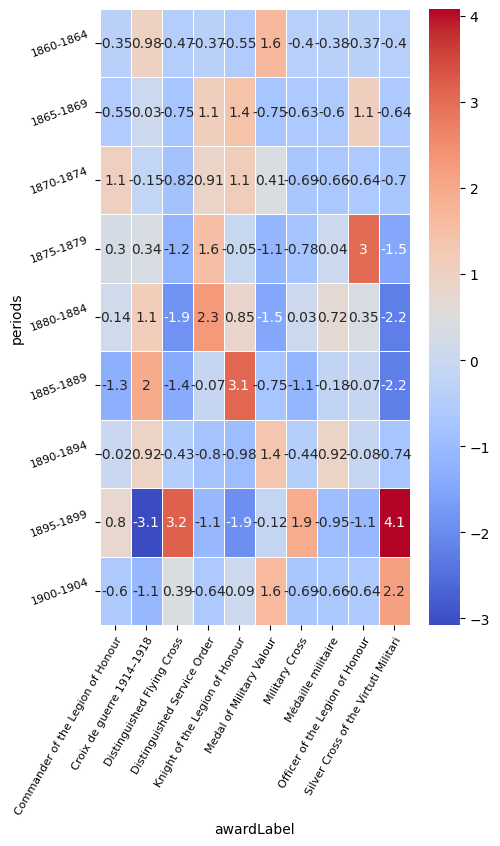

In [72]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

On observe une relation significative entre les deux variables (période de naissance et type de décoration) ce qui s'explique notamment par le fait que les décorations militaires ne sont pas toutes attribuées aux mêmes périodes, ni dans les mêmes contextes historiques.


### On améliore les axes de la table et de la heat map

In [73]:
top_awards = df_prep_cleaned['awardLabel'].value_counts().head(10).index

df_subset = df_prep_cleaned[df_prep_cleaned['awardLabel'].isin(top_awards)]

X = 'periods'        
Y = 'awardLabel'       

ddf = df_subset[[Y, X]].pivot_table(
    index=Y,
    columns=X,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)

ct_wm = ddf.iloc[:-1, :-1].copy(deep=True)  

ct_wm.head() 


C:\Users\menou\AppData\Local\Temp\ipykernel_30276\1184542323.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ddf = df_subset[[Y, X]].pivot_table(


periods,1860-1864,1865-1869,1870-1874,1875-1879,1880-1884,1885-1889,1890-1894,1895-1899,1900-1904
awardLabel,,,,,,,,,
Commander of the Legion of Honour,0,0,1,2,4,3,15,15,0
Croix de guerre 1914–1918,1,1,1,6,16,29,55,20,0
Distinguished Flying Cross,0,0,0,1,2,7,26,38,1
Distinguished Service Order,0,1,1,4,9,7,14,10,0
Knight of the Legion of Honour,0,2,2,4,12,28,32,20,1


In [74]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 142.34 , dof : 72
p-value : 1.5513023984614018e-06
phi2 = inertie (variance totale) : 0.2137268540565366
Cramer:  0.1634498600705032


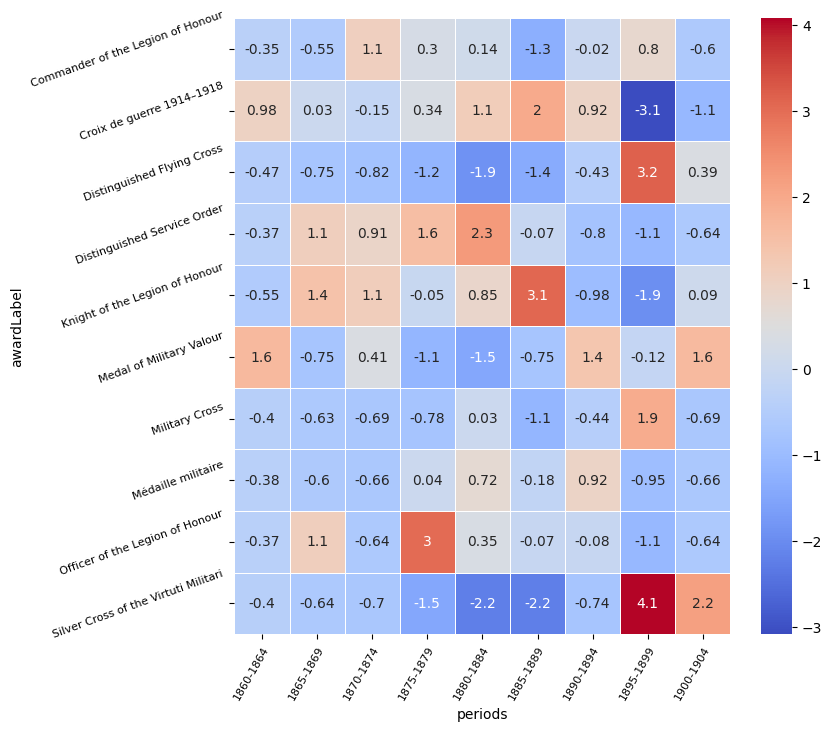

In [75]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

## Prepare graph


Dans une perspective heuristique, nous considérons les pilotes comme des vecteurs de connexions entre les décorations militaires.

Bien entendu, ces connexions sont déterminées par des facteurs temporels (comme les périodes de naissance) et contextuels (tels que l’allégeance ou les phases du conflit), et chaque décoration peut avoir une signification différente. Mais dans cette première exploration générale du champ, nous prenons en compte l’ensemble des décorations attribuées. Des filtres plus spécifiques (par exemple selon l’allégeance ou le type de distinction) pourraient être introduits par la suite.

Nous allons réaliser une projection du graphe sur les décorations, en conservant à ce stade l’ensemble des liens entre pilotes et récompenses, avec une arête par décoration reçue. Les éléments de jonction dans cette projection sont ceux qui concernent un même pilote.

In [76]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(
    df_awards,
    df_awards,
    on=['aceUri', 'aceLabel', 'birthYear', 'periods', 'allegiance_clean']
)

print(len(merged))


14807


In [77]:
### Eliminate double rows :relationship A-B but relationship B-A
# on garde une seule orientation
merged = merged[merged['awardLabel_x'] < merged['awardLabel_y']]


In [78]:
df_awards_unique = df_awards.drop_duplicates(['aceUri','awardLabel'])


In [79]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

6210
['aceUri', 'aceLabel', 'allegianceUri_x', 'allegianceLabel_x', 'awardUri_x', 'awardLabel_x', 'birthYear', 'allegiance_clean', 'periods', 'allegianceUri_y', 'allegianceLabel_y', 'awardUri_y', 'awardLabel_y']


,aceUri,aceLabel,allegianceUri_x,allegianceLabel_x,awardUri_x,awardLabel_x,birthYear,allegiance_clean,periods,allegianceUri_y,allegianceLabel_y,awardUri_y,awardLabel_y
289,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14865220,commander of the Order of the Crown of Italy
290,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q12192290,Knight Grand Cross of the Royal Victorian Order
291,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q12177451,Knight Grand Cross of the Order of the Bath
293,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q1774648,Distinguished Service Medal


In [80]:
### check awards distribution
print(df_awards['awardLabel'].value_counts())


awardLabel
                                                      218
Croix de guerre 1914–1918                             129
Knight of the Legion of Honour                        101
Distinguished Flying Cross                             75
Medal of Military Valour                               74
                                                     ... 
Wound Badge of 20 July 1944 in Gold                     1
Grand Prix du roman de l'Académie française             1
Prince Pierre Award                                     1
Ambassadors' Prize                                      1
Academy Award for Best Writing, Adapted Screenplay      1
Name: count, Length: 503, dtype: int64


In [81]:
### Number of relationships per type prepared for graph
gl_awards = merged.groupby(['awardLabel_x', 'awardLabel_y'], as_index=False).size()

gl_awards = gl_awards.sort_values(by='size', ascending=False)

gl_awards.head()


,awardLabel_x,awardLabel_y,size
1328,Croix de guerre 1914–1918,Knight of the Legion of Honour,43
1351,Croix de guerre 1914–1918,Médaille militaire,38
1353,Croix de guerre 1914–1918,Officer of the Legion of Honour,27
755,Commander of the Legion of Honour,Croix de guerre 1914–1918,22
1592,Cross of Valour,Silver Cross of the Virtuti Militari,19


In [82]:
### Number of relationships per type prepared for graph
gl_awards = (
    merged.groupby(['awardLabel_x', 'awardLabel_y'], as_index=False)
          .size()
          .sort_values(by='size', ascending=False)
)

gl_awards.head()



,awardLabel_x,awardLabel_y,size
1328,Croix de guerre 1914–1918,Knight of the Legion of Honour,43
1351,Croix de guerre 1914–1918,Médaille militaire,38
1353,Croix de guerre 1914–1918,Officer of the Legion of Honour,27
755,Commander of the Legion of Honour,Croix de guerre 1914–1918,22
1592,Cross of Valour,Silver Cross of the Virtuti Militari,19


In [83]:
### Concat relationships
merged['award_concat'] = merged.apply(
    lambda x: x.awardLabel_x + '_' + x.awardLabel_y, axis=1
)

In [84]:
print(list(merged.columns))
merged.iloc[110:112]


['aceUri', 'aceLabel', 'allegianceUri_x', 'allegianceLabel_x', 'awardUri_x', 'awardLabel_x', 'birthYear', 'allegiance_clean', 'periods', 'allegianceUri_y', 'allegianceLabel_y', 'awardUri_y', 'awardLabel_y', 'award_concat']


,aceUri,aceLabel,allegianceUri_x,allegianceLabel_x,awardUri_x,awardLabel_x,birthYear,allegiance_clean,periods,allegianceUri_y,allegianceLabel_y,awardUri_y,awardLabel_y,award_concat
289,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14865220,commander of the Order of the Crown of Italy,Commander of the Order of Leopold_commander of...
290,http://www.wikidata.org/entity/Q336065,"Hugh Trenchard, 1st Viscount Trenchard",http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q14900499,Commander of the Order of Leopold,1873,British Empire,1870-1874,http://www.wikidata.org/entity/Q145,United Kingdom,http://www.wikidata.org/entity/Q12192290,Knight Grand Cross of the Royal Victorian Order,Commander of the Order of Leopold_Knight Grand...


## Analyse du graphe

On va explorer quelques aspects du réseau des décorations :

* Voir quelles décorations sont souvent reliées entre elles par les mêmes pilotes, et si ces regroupements se font par pays.
* Distinguer les décorations nationales (données par le pays du pilote) et les décorations étrangères (données par des alliés), en les regardant séparément.
* Regarder la relation entre décorations nationales et étrangères : est-ce que certaines distinctions vont souvent ensemble ?






In [85]:
## Provide the data in the format 
# required by Networkx

l = [(
        e['awardLabel_x'],      
        e['awardLabel_y'],      
        {'weight': int(e['size'])}  # poids des edges = nombre de pilotes
     )
     for e in gl_awards.to_dict(orient='records')
]

print("Number of edges:", len(l))
l[:5] 

Number of edges: 4566


[('Croix de guerre 1914–1918',
  'Knight of the Legion of Honour',
  {'weight': 43}),
 ('Croix de guerre 1914–1918', 'Médaille militaire', {'weight': 38}),
 ('Croix de guerre 1914–1918',
  'Officer of the Legion of Honour',
  {'weight': 27}),
 ('Commander of the Legion of Honour',
  'Croix de guerre 1914–1918',
  {'weight': 22}),
 ('Cross of Valour', 'Silver Cross of the Virtuti Militari', {'weight': 19})]

In [86]:
award_graph = nx.Graph()

## Add relationships to graph
# Multiple rows between two nodes are taken only once (Graph collapses duplicates).
award_graph.add_edges_from(l)

naf.basic_graph_properties(award_graph)

### Create a list of graphs, one per component
award_graph_S = [award_graph.subgraph(c).copy() for c in nx.connected_components(award_graph)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(award_graph_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 496,
 'number_of_edges': 4566,
 '------': '------',
 'is connected': False,
 'components': 2,
 'density': 0.03719452590420332}
[[0, 494], [1, 2]]


In [87]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [88]:
### Alternative way with just one graph
award_main_graph = award_graph_S[0]
naf.basic_graph_properties(award_main_graph)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 494,
 'number_of_edges': 4565,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.03748840035804912}


In [89]:
df_awardPeriod = (
    merged
    .groupby(['awardLabel_x', 'periods'])['aceUri']
    .nunique()
    .reset_index(name='period_pilot_number')
)



C:\Users\menou\AppData\Local\Temp\ipykernel_30276\2833168896.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['awardLabel_x', 'periods'])['aceUri']


In [90]:
### on compte combien de pilotes concernés par un awards, par period
df_awardPeriod.sort_values(by='period_pilot_number', ascending=False).head(2)


,awardLabel_x,periods,period_pilot_number
727,Croix de guerre 1914–1918,1890-1894,46
726,Croix de guerre 1914–1918,1885-1889,23


In [93]:
df_apl = df_awardPeriod[df_awardPeriod.periods == '1890-1894'][['awardLabel_x', 'period_pilot_number']]
df_apl.columns = ['label', 'nbPilots']
df_apl['mainType'] = 'award'
df_apl.head()


,label,nbPilots,mainType
7,1914–15 Star,0,award
17,1939–45 Star,0,award
27,"Academy Award for Best Writing, Adapted Screen...",0,award
37,Academy Honorary Award,1,award
47,Africa Star,0,award


In [94]:
### Prepare data to add to nodes
ln = dict([
    (e['label'], {
        'label': e['label'],
        'mainType': e['mainType'],
        'nbPilots': e['nbPilots']
    })
    for e in df_apl.to_dict(orient='records')
])
## Add attributes
nx.set_node_attributes(award_graph, ln)
pprint.pprint(list(award_graph.nodes.data())[:2])


[('Croix de guerre 1914–1918',
  {'label': 'Croix de guerre 1914–1918', 'mainType': 'award', 'nbPilots': 46}),
 ('Knight of the Legion of Honour',
  {'label': 'Knight of the Legion of Honour',
   'mainType': 'award',
   'nbPilots': 15})]


In [96]:
mn_s = pd.Series([n[1]['mainType'] for n in award_graph.nodes.data() if 'mainType' in n[1]])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))


award    439
dtype: int64


####  Create dataframe and inspect node properties

In [98]:
### Eigenvector
le = list(nx.eigenvector_centrality(award_graph, max_iter=200, weight='weight').items())
nx.set_node_attributes(award_graph, dict(le), 'eigenvector')

pprint.pprint(list(award_graph.nodes.data())[:1])

[('Croix de guerre 1914–1918',
  {'eigenvector': 0.5599015010582713,
   'label': 'Croix de guerre 1914–1918',
   'mainType': 'award',
   'nbPilots': 46})]


In [99]:
### Betweenness
lb = list(nx.betweenness_centrality(award_graph, weight='weight').items())
nx.set_node_attributes(award_graph, dict(lb), 'betweenness')
pprint.pprint(list(award_graph.nodes.data())[:1])


[('Croix de guerre 1914–1918',
  {'betweenness': 0.12019198165730888,
   'eigenvector': 0.5599015010582713,
   'label': 'Croix de guerre 1914–1918',
   'mainType': 'award',
   'nbPilots': 46})]


In [100]:
### Export node attributes to dataframe
nodes_data ={node: award_graph.nodes[node] for node in award_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,nbPilots,eigenvector,betweenness
0,Croix de guerre 1914–1918,Croix de guerre 1914–1918,award,46,0.559902,0.120192
1,Knight of the Legion of Honour,Knight of the Legion of Honour,award,15,0.4181,0.106979


In [102]:
print(nodes_df.columns)

Index(['id', 'label', 'mainType', 'nbPilots', 'eigenvector', 'betweenness'], dtype='object')


In [103]:
df_mainTypes = nodes_df['mainType'].value_counts()
print(df_mainTypes)

mainType
award    439
Name: count, dtype: int64


In [106]:
# Pour éviter un graph trop visualement chargé, on filtre sur les 10 awards les plus fréquents
nodes_filtered = nodes_df.sort_values(by='nbPilots', ascending=False).head(10)
nodes_to_keep = nodes_filtered['id'].tolist()
award_graph_filtered = award_graph.subgraph(nodes_to_keep).copy()



In [109]:
### source
# https://phrogz.net/css/distinct-colors.html
lt = nodes_filtered['id'].tolist()  # these are the top 10 award labels
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e']


In [110]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('Croix de guerre 1914–1918', '#ff0066'), ('Knight of the Legion of Honour', '#0000ff'), ('Distinguished Flying Cross', '#00aaff'), ('Commander of the Legion of Honour', '#beb6f2'), ('Distinguished Service Order', '#b6e6f2'), ('Air Force Cross', '#e6f2b6'), ('Order of Saint Anna, 4th class', '#f2b6b6'), ('Order of Saint Stanislaus', '#2d50b3'), ('Companion of the Order of the Bath', '#ccff00'), ('Médaille militaire', '#8c005e')]


In [111]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'Air Force Cross': '#e6f2b6',
 'Commander of the Legion of Honour': '#beb6f2',
 'Companion of the Order of the Bath': '#ccff00',
 'Croix de guerre 1914–1918': '#ff0066',
 'Distinguished Flying Cross': '#00aaff',
 'Distinguished Service Order': '#b6e6f2',
 'Knight of the Legion of Honour': '#0000ff',
 'Médaille militaire': '#8c005e',
 'Order of Saint Anna, 4th class': '#f2b6b6',
 'Order of Saint Stanislaus': '#2d50b3'}


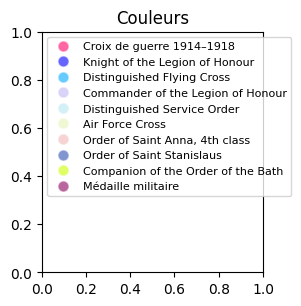

In [121]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()
types_list = list(color_map.keys())


In [122]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.5216149697914754 0.12247685278450465


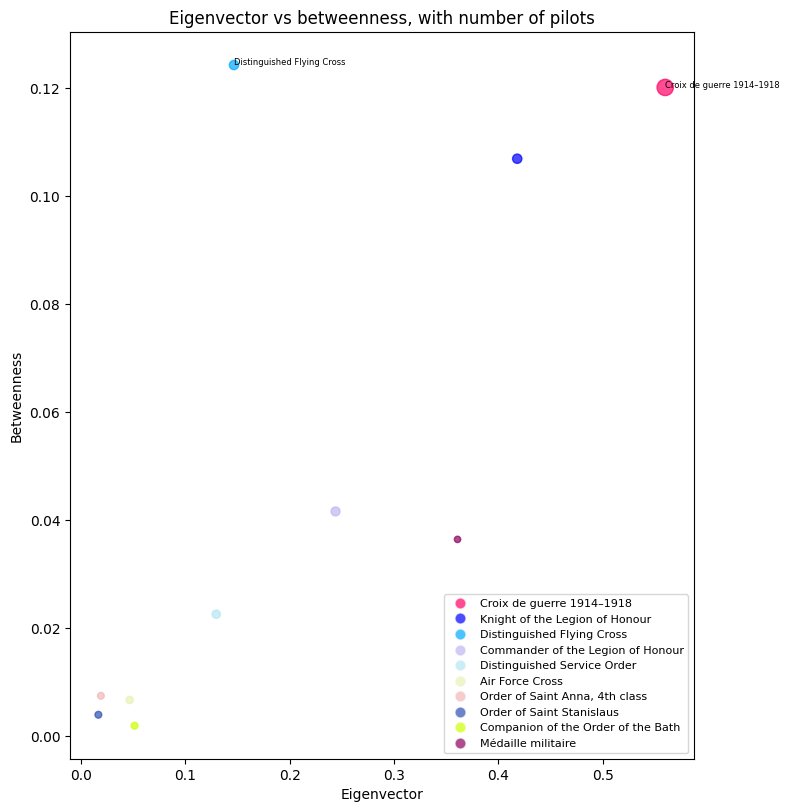

Spearman's rank correlation: 0.7818181818181819


In [123]:
compare_with_scatter_plot(nodes_filtered, 'eigenvector', 'betweenness', 'nbPilots', 
                          point_ratio=3, c_category='id',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of pilots', 
                          n_label='label', label_cut_value='nbPilots' )

corr_spear = nodes_filtered[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [124]:
list(nodes_filtered.columns)

['id', 'label', 'mainType', 'nbPilots', 'eigenvector', 'betweenness']

In [126]:
print('Betweenness')
pprint.pprint((nodes_filtered.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'nbPilots']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_filtered.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'nbPilots']].head(7)))

Betweenness
                                label mainType nbPilots
19         Distinguished Flying Cross    award       15
0           Croix de guerre 1914–1918    award       46
1      Knight of the Legion of Honour    award       15
4   Commander of the Legion of Honour    award       14
2                  Médaille militaire    award        7
12        Distinguished Service Order    award       12
35     Order of Saint Anna, 4th class    award        8

-----
Eigenvector
                                 label mainType nbPilots
0            Croix de guerre 1914–1918    award       46
1       Knight of the Legion of Honour    award       15
2                   Médaille militaire    award        7
4    Commander of the Legion of Honour    award       14
19          Distinguished Flying Cross    award       15
12         Distinguished Service Order    award       12
16  Companion of the Order of the Bath    award        8


#### Plot graph

In [128]:
p = '1914-1918'
pict_addr = 'images/awards/awards_network' + p +'.svg'
print(pict_addr)

images/awards/awards_network1914-1918.svg


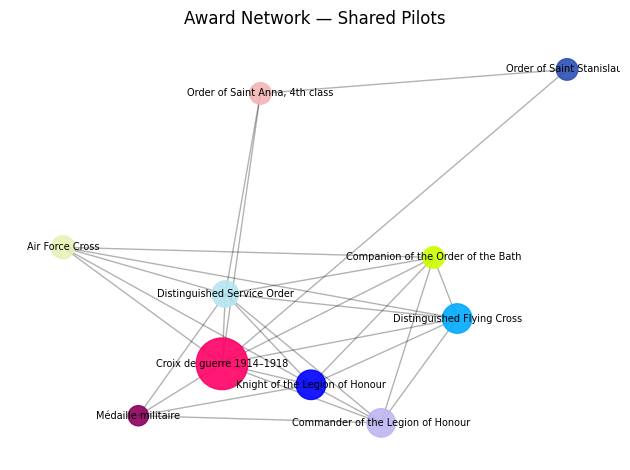

In [ ]:
G = award_graph_filtered

# position des noeuds
pos = nx.spring_layout(G, seed=42)

# taille et couleur
node_sizes = [G.nodes[n]['nbPilots'] * 30 for n in G.nodes()]
node_colors = [color_map.get(n, '#cccccc') for n in G.nodes()]  # fallback to gray


nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.9)

nx.draw_networkx_edges(G, pos, alpha=0.3)

nx.draw_networkx_labels(G, pos,
                        labels={n: n for n in G.nodes()},
                        font_size=7)

plt.title('Award Network — Shared Pilots')
plt.axis('off')
plt.tight_layout()
plt.show()

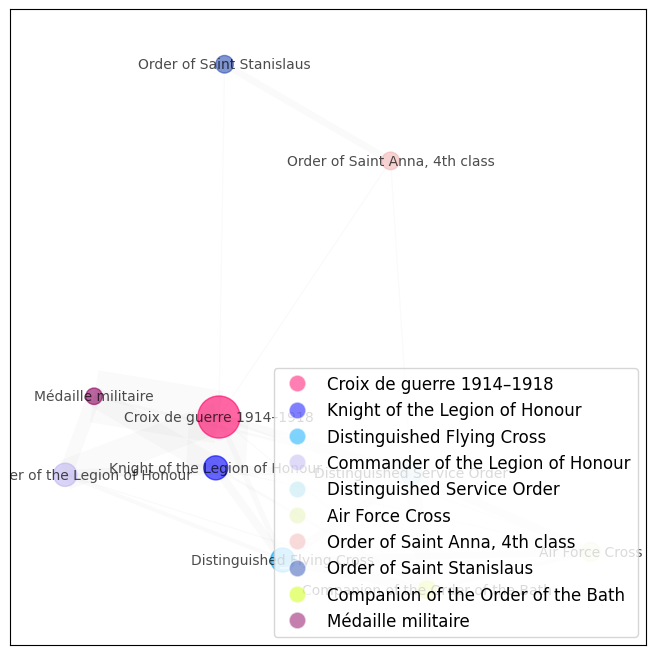

In [134]:
### Plot the graph

g = award_graph_filtered
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['nbPilots']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors = [color_map.get(n[0], '#cccccc') for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
#plt.savefig(pict_addr)
plt.show()
plt.close()
